In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import defaultdict


In [10]:
def get_label(path: Path) -> str:
    path_split = str(path).split("\\")
    return "-".join(path_split[1:-2])

def natural_sort(text):
    def a2i(_text: str):
        return int(_text) if _text.isdigit() else _text
    
    return [a2i(t) for t in re.split(r"(\d+)", text)]


In [11]:
TEST_CASE = "t8_n6"

current_dir = Path()
bounds_paths = list(current_dir.glob(f"{TEST_CASE}/**/bounds.csv"))
dual_solver_paths = list(current_dir.glob(f"{TEST_CASE}/**/dual_solver.csv"))

In [12]:
result_paths = defaultdict(dict)

labels = []

for path in bounds_paths:
    label = get_label(path)
    result_paths[label]["bounds"] = path

for path in dual_solver_paths:
    label = get_label(path)
    result_paths[label]["dual_solver"] = path

result_paths = {k: result_paths[k] for k in sorted(result_paths.keys(), key=natural_sort)}

In [13]:
lagrange_markers = {}

for label, paths in result_paths.items():
    ds_df = pd.read_csv(paths["dual_solver"], sep="\t")
    lagrange_markers[label] = [x for x in ds_df.i.unique().tolist()]

In [14]:
lower_bounds = {}

for label, paths in result_paths.items():
    df = pd.read_csv(paths["bounds"], sep="\t")
    ub = df.ub_r.values[-1]
    lbs = df.lb.div(ub).tolist()
    lbs.pop()
    lower_bounds[label] = lbs

In [15]:
sorted(result_paths.keys())

['classical-10',
 'classical-15-l',
 'classical-15-l+sb',
 'classical-5',
 'dynamic']

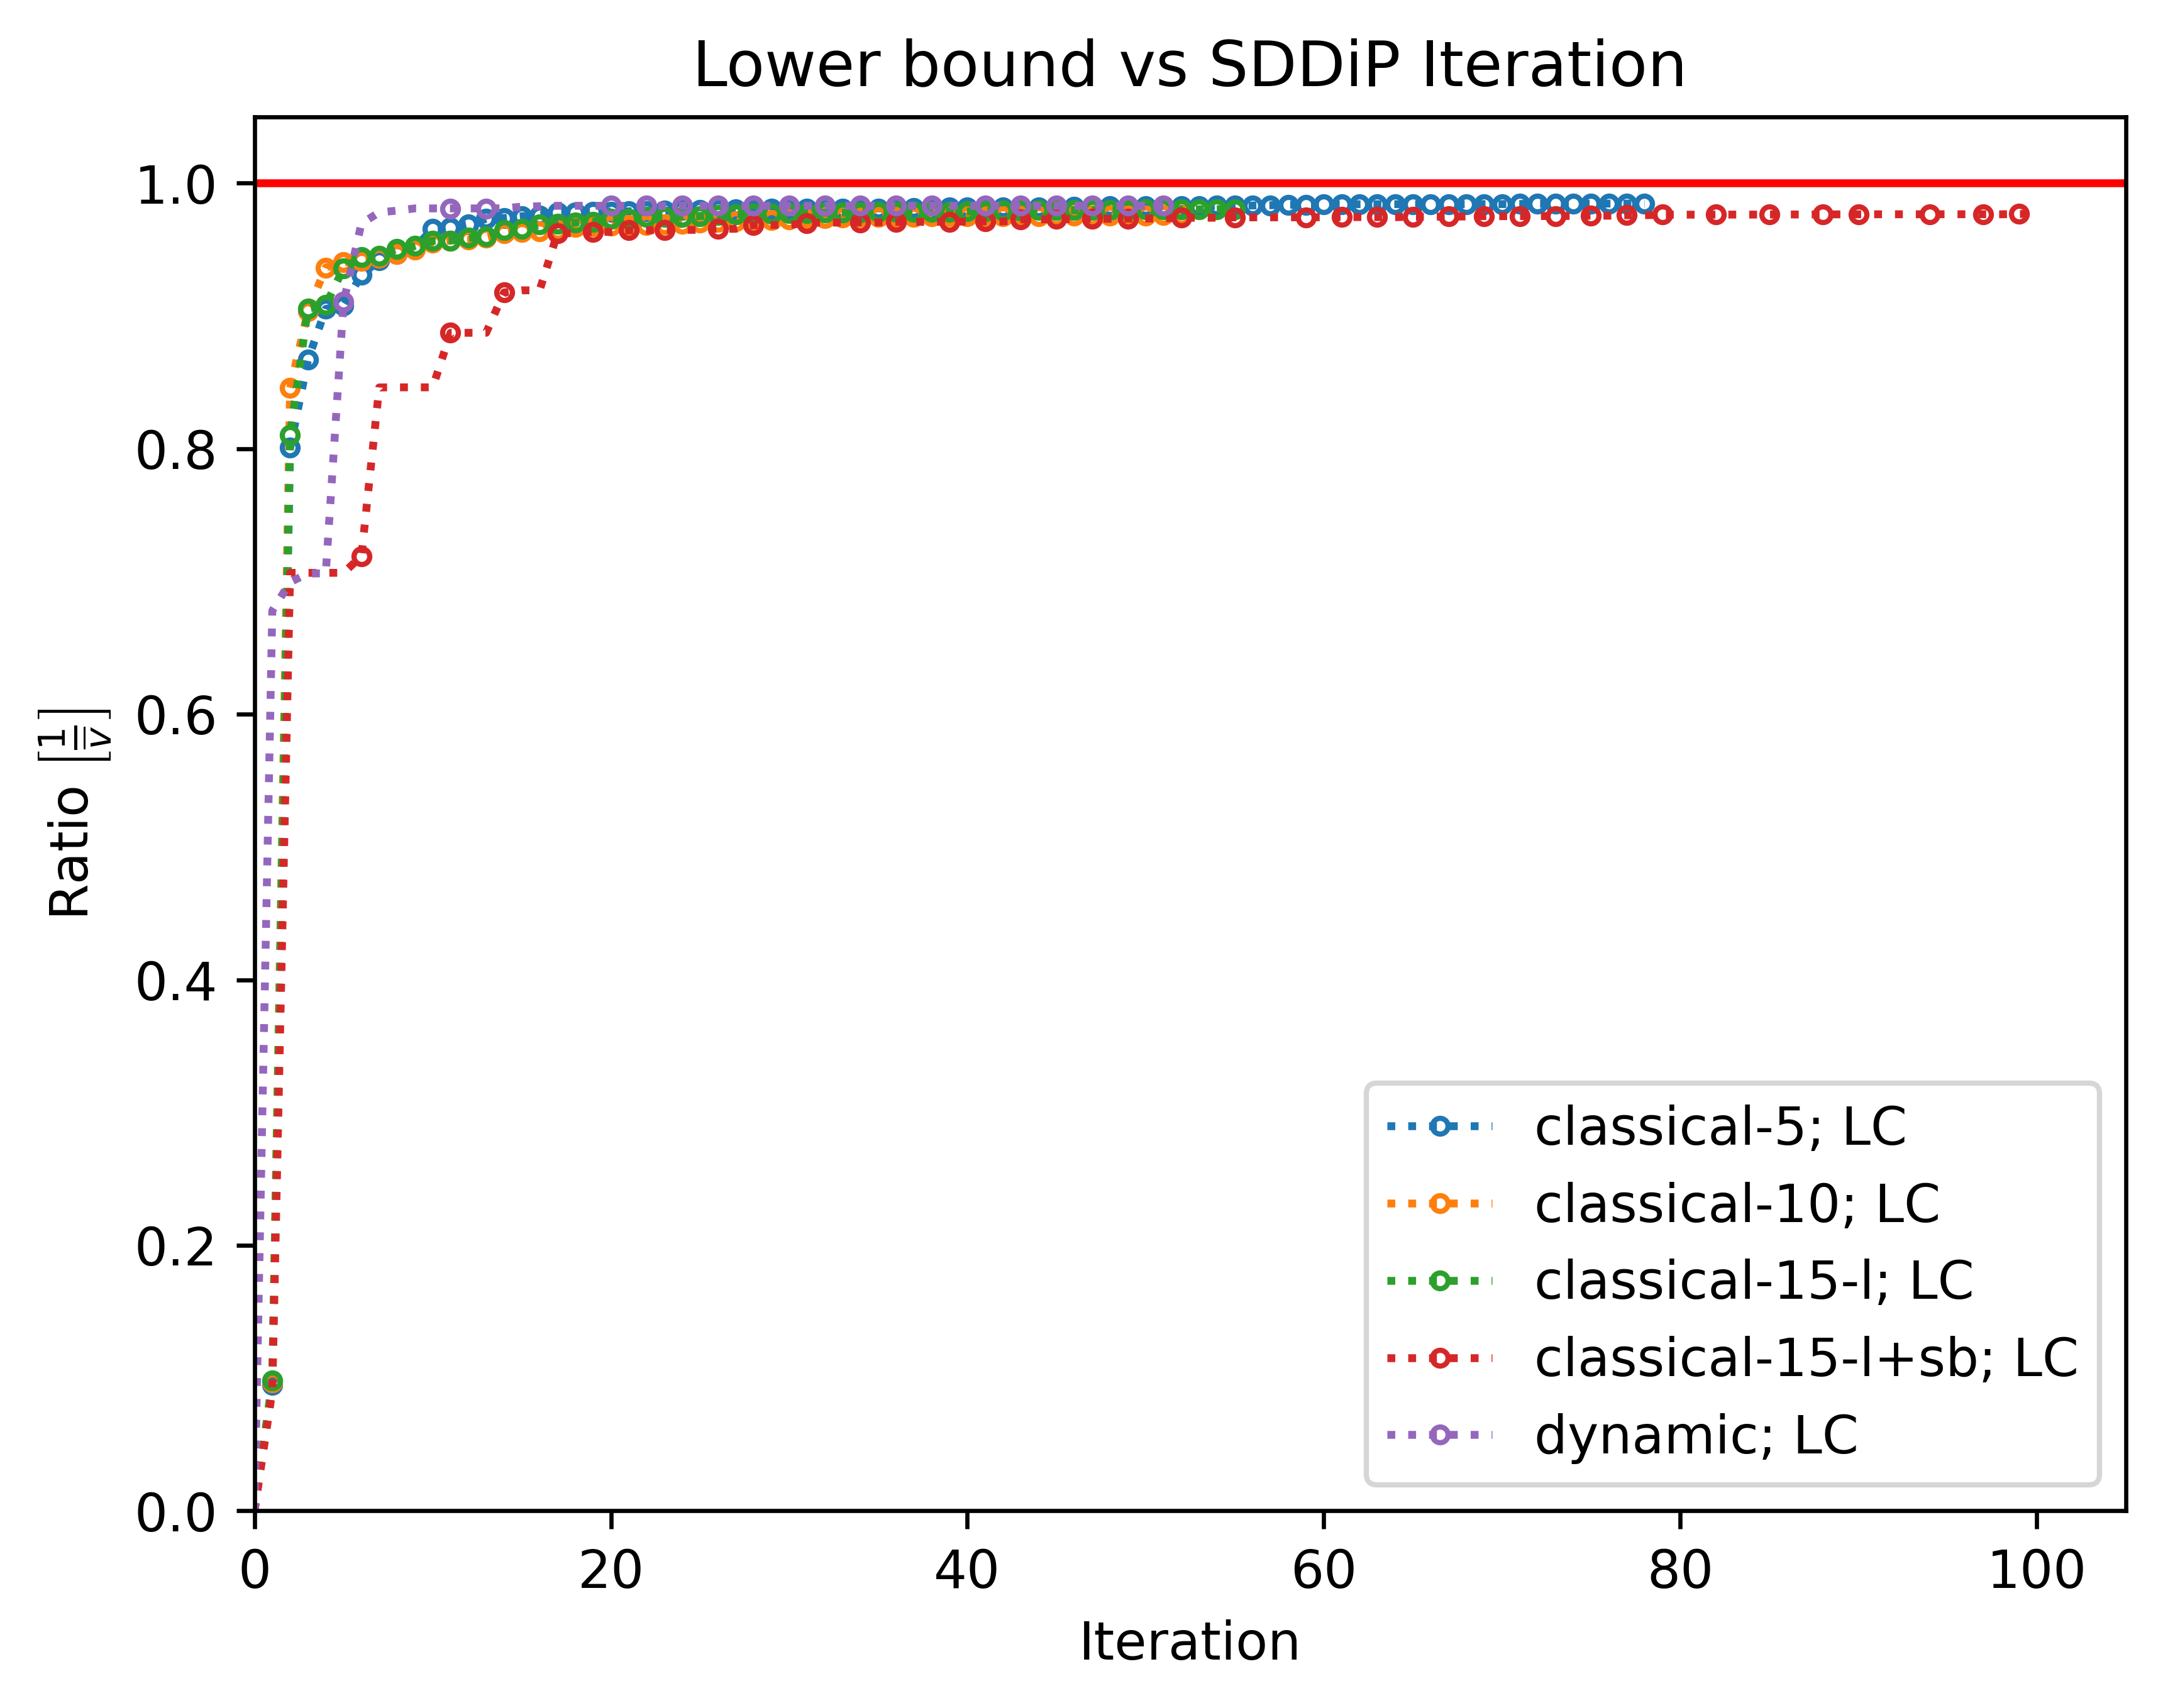

In [16]:
plt.figure(dpi= 600, facecolor='w', edgecolor='k')

plt.axhline(y=1, color="r", linestyle='-')
#plt.axhline(y=ub_r/ub_l, color="g", linestyle='-')

for label in result_paths.keys():
    values = [0] + lower_bounds[label]    
    iterations = [i for i in range(len(values))]
    markers = lagrange_markers[label]
    plt.plot(iterations, values, ".", ls=':', markevery=markers, markerfacecolor="None", label=f"{label}; LC")

plt.gca().set(xlabel="Iteration", ylabel=r"Ratio $\left[\frac{1}{\overline{v}}\right]$")
plt.title("Lower bound vs SDDiP Iteration")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend(loc=4)
plt.savefig(f"{TEST_CASE}_convergence.png")
plt.show()